 ## Data Field Information

### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

### test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

### stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

### oil.csv
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

### holidays_events.csv
- Holidays and Events, with metadata
- NOTE - Transferred column: A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

### Additional Notes
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## Import Libraries

In [123]:
# Essential libraries for time series forecasting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from termcolor import colored

# Set up the plotting environment
import seaborn as sns
import matplotlib.pyplot as plt
# Set Seaborn style for better-looking plots
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

# Utility
import warnings
from datetime import datetime, timedelta
import os
from tabulate import tabulate

# Custom function for RMSLE (competition metric)
def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error"""
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
pd.set_option('display.max_columns', None)
np.random.seed(42)

## Import Data

In [124]:
# Set the file path and name
train_path = './data/train.csv'
test_path = './data/test.csv'
transactions_path = './data/transactions.csv'
oil_path = './data/oil.csv'
holidays_events_path = './data/holidays_events.csv'

# Read the CSV file into a Pandas DataFrame
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
transactions_df = pd.read_csv(transactions_path)
oil_df = pd.read_csv(oil_path)
holidays_events_df = pd.read_csv(holidays_events_path)

In [125]:
# Quick overview of all datasets
print("Dataset shapes:")
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Transactions: {transactions_df.shape}")
print(f"Oil: {oil_df.shape}")
print(f"Holidays/Events: {holidays_events_df.shape}")

Dataset shapes:
Train: (3000888, 6)
Test: (28512, 5)
Transactions: (83488, 3)
Oil: (1218, 2)
Holidays/Events: (350, 6)


## Utility Module

In [126]:
# Function to print main information about a dataset
def ds_info(df):
    print(colored('SIZE' , 'blue', attrs=['bold', 'dark']))
    print(df.size)
    print(colored('\nSHAPE' , 'blue', attrs=['bold', 'dark']))
    print(df.shape)
    print(colored('\nINFO' , 'blue', attrs=['bold', 'dark']))
    print(df.info())
    print(colored('\nNULL VALUES' , 'blue', attrs=['bold', 'dark']))
    print(df.isnull().sum())
    print(colored('\nHEAD' , 'blue', attrs=['bold', 'dark']))
    print(df.head())
    print(colored('\nTAIL' , 'blue', attrs=['bold', 'dark']))
    print(df.tail())
    print(colored('\nDESCRIBE - Numerical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe())
    print(colored('\nDESCRIBE - Categorical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe(include='object'))
    
    print(colored('\nUNIQUE ENTRIES IN EACH NUMERICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    
    # Get number of unique entries in each column with numerical data
    num_cols = [col for col in df.columns if df[col].dtype != "object"]
    num_nunique = list(map(lambda col: df[col].nunique(), num_cols))    
    dn = dict(zip(num_cols, num_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dn.items(), key=lambda x: x[1]))
    
    print(colored('\nUNIQUE ENTRIES IN EACH CATEGORICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with categorical data
    object_cols = [col for col in df.columns if df[col].dtype == "object"]
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    dc = dict(zip(object_cols, object_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dc.items(), key=lambda x: x[1]))
    
    
# Function to parse date 
def parse_datetime(data):
    #convert date.datetime to type datetime 
    data.datetime = pd.to_datetime(data.datetime)
    # split in columns
    data['year'] = data['datetime'].dt.year
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data['weekday'] = data['datetime'].dt.weekday
    
    
# Function to detect and print outliers 
def detect_outliers(data):
    # mean, standard deviation and 3-sigma of the data
    mean = np.mean(data)
    std = np.std(data)
    threesigma = 3 * std
    
    # print upper, lower boundary and boxplot
    sns.boxplot(data, orient="v")
    plt.show()
    lower, upper = mean-3*std, mean+3*std
    print(f"Upper and lower boundary is: {lower}/{upper}")
    
    # identify outliers and return the outliers
    outliers = [x for x in data if np.abs(x - mean) > threesigma]
    print(f"There are {len(outliers)} outliers based on three-sigma rule")

    
# Function to delete the outliers 
def delete_outliers(data, df):
    """ Detecting and dropping outliers """
    original_shape = df.shape
    mean = np.mean(data)
    std = np.std(data)
    outliers = np.abs(data-mean) > (3*std)
    outliers_num = len(train[outliers])
    df.drop(index=data[outliers].index, inplace=True)
    
    # print what was deleted
    print("Number of outliers deleted:", outliers_num)
    print ("Shape of dataframe with Ouliers: ",original_shape)
    print ("Shape of Dataframe After Deleting the Ouliers: ",df.shape)

    
# Function to plot the Correlation Heatmap
def correlation_heatmap(corr):
    """ Correlation Heatmap """
    mask = np.array(corr)
    mask[np.tril_indices_from(mask)] = False
    
    # plot the correlation
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)
    sns.heatmap(corr, mask=mask,vmax=.8, square=True,annot=True)

# Function to calculate RMSLE - Root Mean Squared Logarithmic Error   
def rmsle(y_true, y_pred):
    """ Custom RMSLE scorer function."""
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))
    

def check_date_columns(df):
    """Identify and analyze date columns"""
    date_cols = []
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                pd.to_datetime(df[col].head(100))
                date_cols.append(col)
            except:
                pass
    print(colored('POTENTIAL DATE COLUMNS:', 'yellow', attrs=['bold']))
    print(date_cols)
    return date_cols


def missing_data_summary(df):
    """Enhanced missing data analysis"""
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    missing_table = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_pct
    }).sort_values('Missing %', ascending=False)
    return missing_table[missing_table['Missing Count'] > 0]


def plot_time_series(df, date_col, value_col, title="Time Series"):
    """Quick time series plot"""
    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(df[date_col]), df[value_col])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Dataset  Overview

In [127]:
# Quick overview of all datasets
datasets = {
    'Train': train_df,
    'Test': test_df, 
    'Transactions': transactions_df,
    'Oil': oil_df,
    'Holidays/Events': holidays_events_df
}

for name, df in datasets.items():
    print(f"{name}: {df.shape} - Columns: {list(df.columns)}")

Train: (3000888, 6) - Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
Test: (28512, 5) - Columns: ['id', 'date', 'store_nbr', 'family', 'onpromotion']
Transactions: (83488, 3) - Columns: ['date', 'store_nbr', 'transactions']
Oil: (1218, 2) - Columns: ['date', 'dcoilwtico']
Holidays/Events: (350, 6) - Columns: ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']


In [128]:
for name, df in datasets.items():
    print(f"\n{'='*50}")
    print(f"ANALYZING {name.upper()} DATASET")
    print('='*50)
    ds_info(df)
    print("\n" + "="*70 + "\n")


ANALYZING TRAIN DATASET
SIZE
18005328

SHAPE
(3000888, 6)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

NULL VALUES
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

HEAD
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

TAIL
              id        date  store_nbr 

#### Summary

**Training Data (3M+ records)**
- Period: 2013-01-01 to 2017-08-15 (4.5+ years)
- Structure: 54 stores × 33 product families × daily data
- Target: Sales values (0 to 124,717 range, many zeros)
- Key insight: 25% of records have zero sales (seasonal/sparse data)
- No NULL values

**Test Data (28K records)**
- Period: 2017-08-16 to 2017-08-31 (16 days)
- Task: Predict sales for these 16 days
- Same structure: 54 stores × 33 product families
- Transactions Data (83K records)

**Daily transaction counts per store**
- Range: 5 to 8,359 transactions per day
- Useful for: Understanding store traffic patterns

**Oil Prices (1.2K records)**
- Daily oil prices (Ecuador is oil-dependent)
- 43 missing values (3.5% missing)

**Range: 26−111 per barrel**
Trend: Declining from ~ 100 (2013) to 100(2013) to 47 (2017)

**Holidays/Events (350 records)**
- 6 types: Holiday, Additional, Bridge, Transfer, Work Day, Event
- 3 scopes: National (174), Regional, Local
- 12 transferred holidays (important for modeling)

## Data Preprocessing

#### Data Type Conversion

In [129]:
# Convert date columns to datetime for all datasets
datasets_to_convert = [
    ('train_df', train_df),
    ('test_df', test_df), 
    ('transactions_df', transactions_df),
    ('oil_df', oil_df),
    ('holidays_events_df', holidays_events_df)
]

for name, df in datasets_to_convert:
    print(f"Converting dates in {name}...")
    df['date'] = pd.to_datetime(df['date'])
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Total days: {(df['date'].max() - df['date'].min()).days + 1}")
    print("-" * 50)

Converting dates in train_df...
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Total days: 1688
--------------------------------------------------
Converting dates in test_df...
Date range: 2017-08-16 00:00:00 to 2017-08-31 00:00:00
Total days: 16
--------------------------------------------------
Converting dates in transactions_df...
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Total days: 1688
--------------------------------------------------
Converting dates in oil_df...
Date range: 2013-01-01 00:00:00 to 2017-08-31 00:00:00
Total days: 1704
--------------------------------------------------
Converting dates in holidays_events_df...
Date range: 2012-03-02 00:00:00 to 2017-12-26 00:00:00
Total days: 2126
--------------------------------------------------


In [130]:
# Check for any date gaps or overlaps
print("=== DATE COVERAGE ANALYSIS ===")

# Training period
train_start, train_end = train_df['date'].min(), train_df['date'].max()
print(f"Training: {train_start} to {train_end}")

# Test period  
test_start, test_end = test_df['date'].min(), test_df['date'].max()
print(f"Test: {test_start} to {test_end}")

# Check if test immediately follows training
gap_days = (test_start - train_end).days
print(f"Gap between train and test: {gap_days} days")

# Check for missing dates in training
date_range = pd.date_range(start=train_start, end=train_end, freq='D')
missing_dates = set(date_range) - set(train_df['date'].unique())
print(f"Missing dates in training: {len(missing_dates)}")
if missing_dates:
    print(f"First few missing: {sorted(list(missing_dates))[:5]}")

=== DATE COVERAGE ANALYSIS ===
Training: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test: 2017-08-16 00:00:00 to 2017-08-31 00:00:00
Gap between train and test: 1 days
Missing dates in training: 1688
First few missing: [Timestamp('2013-01-01 00:00:00', freq='D'), Timestamp('2013-01-02 00:00:00', freq='D'), Timestamp('2013-01-03 00:00:00', freq='D'), Timestamp('2013-01-04 00:00:00', freq='D'), Timestamp('2013-01-05 00:00:00', freq='D')]


#### Data Cleaning

**1. Check for duplicate records**

In [131]:
print("=== CHECKING FOR DUPLICATES ===")
for name, df in [('train', train_df), ('test', test_df), ('transactions', transactions_df)]:
    duplicates = df.duplicated().sum()
    print(f"{name}: {duplicates} duplicate rows")
    
    # Check for logical duplicates (same date, store, family)
    if 'family' in df.columns:
        logical_dups = df.duplicated(subset=['date', 'store_nbr', 'family']).sum()
        print(f"{name}: {logical_dups} logical duplicates (same date/store/family)")

=== CHECKING FOR DUPLICATES ===
train: 0 duplicate rows
train: 0 logical duplicates (same date/store/family)
test: 0 duplicate rows
test: 0 logical duplicates (same date/store/family)
transactions: 0 duplicate rows


**2. Check for negative sales (business logic issue)**

In [132]:
negative_sales = (train_df['sales'] < 0).sum()
print(f"\nNegative sales records: {negative_sales}")


Negative sales records: 0


**3. Check date consistency**

In [133]:
print(f"\n=== DATE CONSISTENCY ===")
print(f"Train date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")


=== DATE CONSISTENCY ===
Train date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test date range: 2017-08-16 00:00:00 to 2017-08-31 00:00:00


**4. Check store/family consistency across datasets**

In [134]:
print(f"\n=== STORE/FAMILY CONSISTENCY ===")
train_stores = set(train_df['store_nbr'].unique())
test_stores = set(test_df['store_nbr'].unique())
print(f"Stores in train but not test: {train_stores - test_stores}")
print(f"Stores in test but not train: {test_stores - train_stores}")


=== STORE/FAMILY CONSISTENCY ===
Stores in train but not test: set()
Stores in test but not train: set()


#### Missing Values

Only Oil dataset contains missing values. 

In [135]:
# Analyze missing oil price patterns
print("=== MISSING OIL PRICES ANALYSIS ===")
print(f"Total missing: {oil_df['dcoilwtico'].isnull().sum()}")
print(f"Percentage missing: {oil_df['dcoilwtico'].isnull().mean()*100:.2f}%")

# Check if missing values are clustered or scattered
missing_dates = oil_df[oil_df['dcoilwtico'].isnull()]['date']
print(f"\nFirst few missing dates:")
print(missing_dates.head(10))

# Check for patterns (weekends, holidays, etc.)
oil_df['day_of_week'] = oil_df['date'].dt.day_name()
missing_by_day = oil_df[oil_df['dcoilwtico'].isnull()]['day_of_week'].value_counts()
print(f"\nMissing values by day of week:")
print(missing_by_day)


=== MISSING OIL PRICES ANALYSIS ===
Total missing: 43
Percentage missing: 3.53%

First few missing dates:
0     2013-01-01
14    2013-01-21
34    2013-02-18
63    2013-03-29
104   2013-05-27
132   2013-07-04
174   2013-09-02
237   2013-11-28
256   2013-12-25
261   2014-01-01
Name: date, dtype: datetime64[ns]

Missing values by day of week:
Monday       23
Friday        9
Thursday      7
Tuesday       2
Wednesday     2
Name: day_of_week, dtype: int64


Linear interpolation was choosen because oil price change gradually and interpolation preserves the trend.

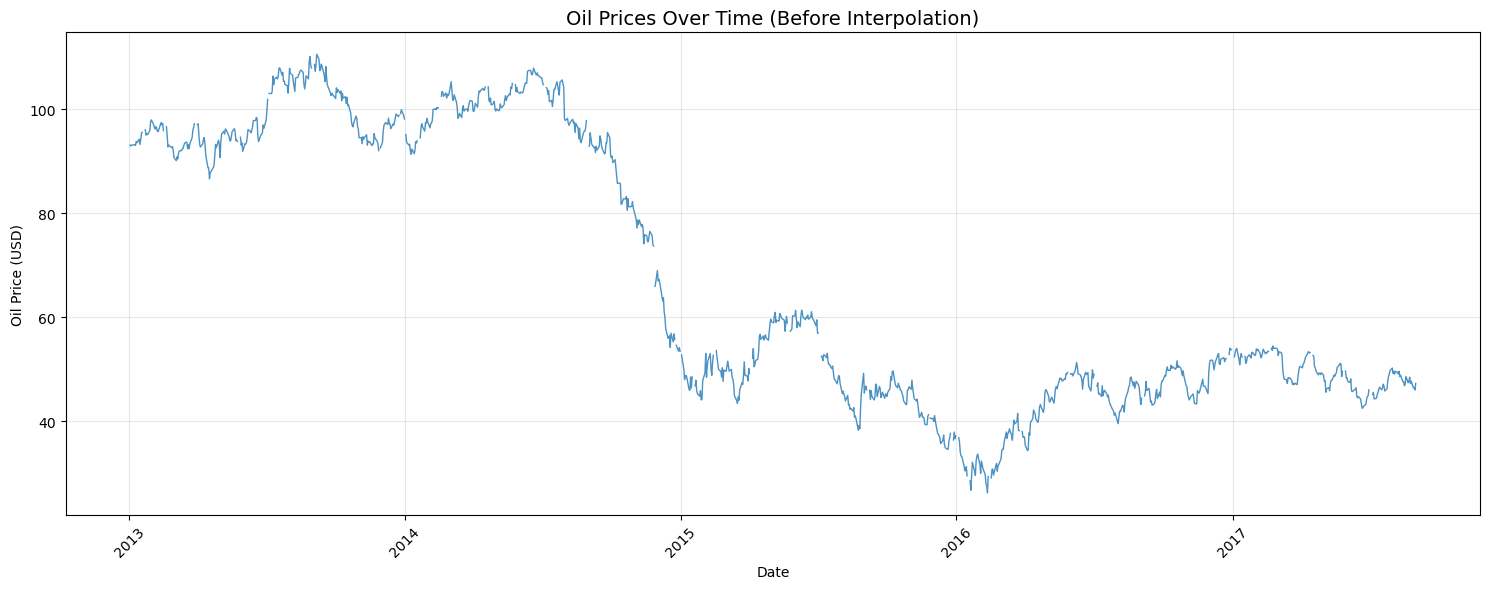

In [136]:
# Visualization to see not interpolated values
plt.figure(figsize=(15, 6))
plt.plot(oil_df['date'], oil_df['dcoilwtico'], linewidth=1, alpha=0.8)
plt.title('Oil Prices Over Time (Before Interpolation)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [137]:
# Linear interpolation to fill missing oil prices
print("=== APPLYING LINEAR INTERPOLATION ===")
print(f"Missing values before: {oil_df['dcoilwtico'].isnull().sum()}")
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='linear')
print(f"Missing values after: {oil_df['dcoilwtico'].isnull().sum()}")

# Verify the interpolation worked
print(f"\nOil price range after interpolation:")
print(f"Min: ${oil_df['dcoilwtico'].min():.2f}")
print(f"Max: ${oil_df['dcoilwtico'].max():.2f}")
print(f"Mean: ${oil_df['dcoilwtico'].mean():.2f}")

=== APPLYING LINEAR INTERPOLATION ===
Missing values before: 43
Missing values after: 1

Oil price range after interpolation:
Min: $26.19
Max: $110.62
Mean: $67.66


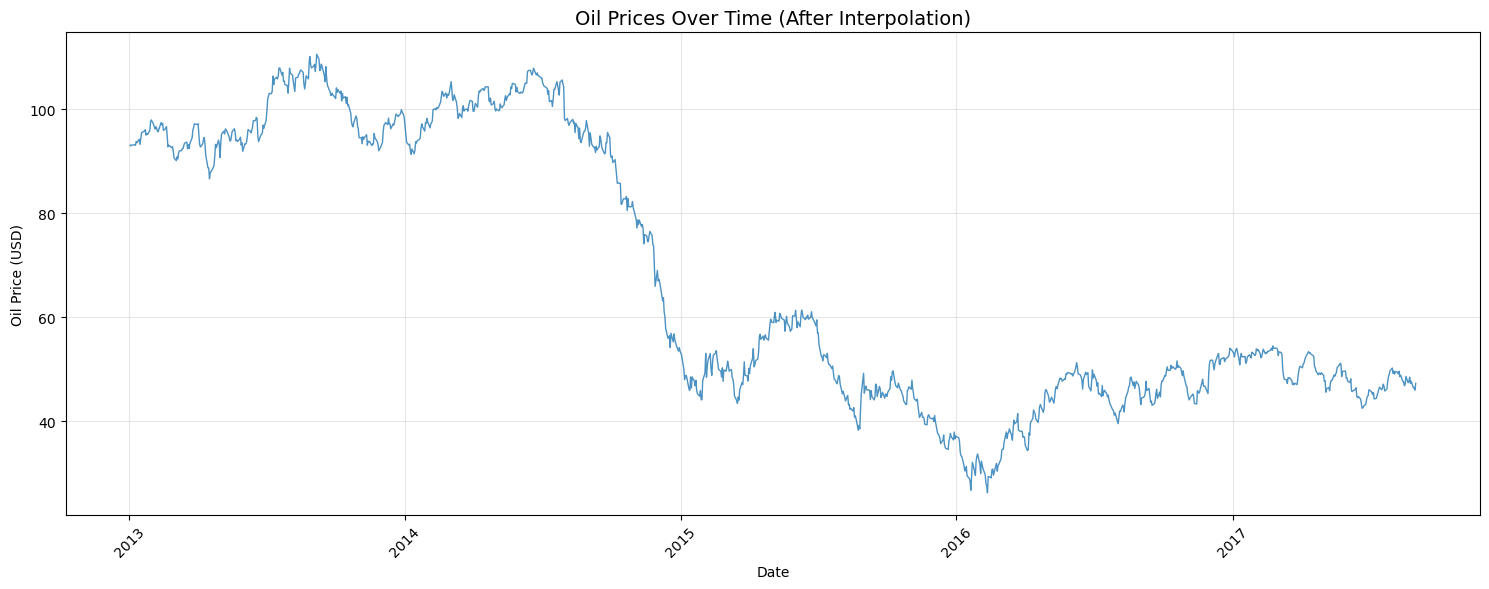


=== SAMPLE OF INTERPOLATED DATA ===
        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
5 2013-01-08       93.21
6 2013-01-09       93.08
7 2013-01-10       93.81


In [138]:
# Visualization to see interpolated values
plt.figure(figsize=(15, 6))
plt.plot(oil_df['date'], oil_df['dcoilwtico'], linewidth=1, alpha=0.8)
plt.title('Oil Prices Over Time (After Interpolation)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show a zoomed view around some interpolated points
print("\n=== SAMPLE OF INTERPOLATED DATA ===")
sample_data = oil_df[oil_df['date'].between('2013-01-01', '2013-01-10')]
print(sample_data[['date', 'dcoilwtico']])


In [139]:
# Final check - ensure no missing values remain in any dataset
print("=== FINAL MISSING VALUES CHECK ===")
datasets = {
    'Train': train_df,
    'Test': test_df,
    'Transactions': transactions_df,
    'Oil': oil_df,
    'Holidays': holidays_events_df
}

for name, df in datasets.items():
    missing = df.isnull().sum().sum()
    print(f"{name}: {missing} missing values")

print("\nMissing value handling complete!")


=== FINAL MISSING VALUES CHECK ===
Train: 0 missing values
Test: 0 missing values
Transactions: 0 missing values
Oil: 1 missing values
Holidays: 0 missing values

Missing value handling complete!


### Feature Engineering

**1. Comprehensive time-based features**

In [140]:
def create_time_features(df):
    """Create time-based features from date column"""
    df = df.copy()
    
    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter
    
    # Weekend indicator
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Month/day names for easier interpretation
    df['month_name'] = df['date'].dt.month_name()
    df['day_name'] = df['date'].dt.day_name()
    
    # Cyclical features (for ML models)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    return df

# Apply to training and test data
print("Creating time features...")
train_df = create_time_features(train_df)
test_df = create_time_features(test_df)

print("Time features created!")
print(f"New columns: {[col for col in train_df.columns if col not in ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']]}")

Creating time features...
Time features created!
New columns: ['year', 'month', 'day', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter', 'is_weekend', 'month_name', 'day_name', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [141]:
# Checking Train dataset
headers = list(train_df.columns)
print(tabulate(train_df[:5], headers=headers, tablefmt="grid"))

+----+------+---------------------+-------------+------------+---------+---------------+--------+---------+-------+---------------+---------------+----------------+-----------+--------------+--------------+------------+-------------+-------------+-----------+-----------+
|    |   id | date                |   store_nbr | family     |   sales |   onpromotion |   year |   month |   day |   day_of_week |   day_of_year |   week_of_year |   quarter |   is_weekend | month_name   | day_name   |   month_sin |   month_cos |   day_sin |   day_cos |
+====+======+=====================+=============+============+=========+===============+========+=========+=======+===============+===============+================+===========+==============+==============+============+=============+=============+===========+===========+
|  0 |    0 | 2013-01-01 00:00:00 |           1 | AUTOMOTIVE |       0 |             0 |   2013 |       1 |     1 |             1 |             1 |              1 |         1 |        

**2. Lag Features (Past sales patterns):**

Lag features are past values of our target variable (sales) shifted by specific time periods. Here is going to be 1 day, 1 week, 2 weeks, 1 month ago.

In [142]:
# Lag features for sales (for forecasting)
def create_lag_features(df, target_col='sales', lags=[1, 7, 14, 28]):
    """Lag features for time series"""
    df = df.copy()
    df = df.sort_values(['store_nbr', 'family', 'date'])
    
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df.groupby(['store_nbr', 'family'])[target_col].shift(lag)
    
    return df

# Apply lag features (only to training data initially)
print("Creating lag features...")
train_df = create_lag_features(train_df)
print("Lag features created!")


Creating lag features...
Lag features created!


In [143]:
# Checking Train dataset
headers = list(train_df.columns)
print(tabulate(train_df[:5], headers=headers, tablefmt="grid"))

+------+------+---------------------+-------------+------------+---------+---------------+--------+---------+-------+---------------+---------------+----------------+-----------+--------------+--------------+------------+-------------+-------------+-----------+-----------+---------------+---------------+----------------+----------------+
|      |   id | date                |   store_nbr | family     |   sales |   onpromotion |   year |   month |   day |   day_of_week |   day_of_year |   week_of_year |   quarter |   is_weekend | month_name   | day_name   |   month_sin |   month_cos |   day_sin |   day_cos |   sales_lag_1 |   sales_lag_7 |   sales_lag_14 |   sales_lag_28 |
+======+======+=====================+=============+============+=========+===============+========+=========+=======+===============+===============+================+===========+==============+==============+============+=============+=============+===========+===========+===============+===============+===============

**3. Rolling Window Features (Trends and patterns):**

To detect trends, baseline forecasting and anomaly detection, we are applying rolling mean and rolling standat deviation for 7, 14 and 28 days.

In [144]:
# Rolling window statistics
def create_rolling_features(df, target_col='sales', windows=[7, 14, 28]):
    """Rolling window features"""
    df = df.copy()
    df = df.sort_values(['store_nbr', 'family', 'date'])
    
    for window in windows:
        # Rolling mean
        df[f'{target_col}_rolling_mean_{window}'] = df.groupby(['store_nbr', 'family'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        
        # Rolling std (volatility)
        df[f'{target_col}_rolling_std_{window}'] = df.groupby(['store_nbr', 'family'])[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
    
    return df

print("Creating rolling features...")
train_df = create_rolling_features(train_df)
print("Rolling features created!")

Creating rolling features...
Rolling features created!


In [145]:
# Checking Train dataset
headers = list(train_df.columns)
print(tabulate(train_df[:5], headers=headers, tablefmt="grid"))

+------+------+---------------------+-------------+------------+---------+---------------+--------+---------+-------+---------------+---------------+----------------+-----------+--------------+--------------+------------+-------------+-------------+-----------+-----------+---------------+---------------+----------------+----------------+------------------------+-----------------------+-------------------------+------------------------+-------------------------+------------------------+
|      |   id | date                |   store_nbr | family     |   sales |   onpromotion |   year |   month |   day |   day_of_week |   day_of_year |   week_of_year |   quarter |   is_weekend | month_name   | day_name   |   month_sin |   month_cos |   day_sin |   day_cos |   sales_lag_1 |   sales_lag_7 |   sales_lag_14 |   sales_lag_28 |   sales_rolling_mean_7 |   sales_rolling_std_7 |   sales_rolling_mean_14 |   sales_rolling_std_14 |   sales_rolling_mean_28 |   sales_rolling_std_28 |
+======+======+===

**4. Store and Family Features:**

In [146]:
# Create store and family-based features
def create_store_family_features(df):
    """Aggregated features by store and family"""
    df = df.copy()
    
    # Store-level features
    store_stats = df.groupby('store_nbr')['sales'].agg(['mean', 'std', 'max']).reset_index()
    store_stats.columns = ['store_nbr', 'store_avg_sales', 'store_std_sales', 'store_max_sales']
    df = df.merge(store_stats, on='store_nbr', how='left')
    
    # Family-level features
    family_stats = df.groupby('family')['sales'].agg(['mean', 'std', 'max']).reset_index()
    family_stats.columns = ['family', 'family_avg_sales', 'family_std_sales', 'family_max_sales']
    df = df.merge(family_stats, on='family', how='left')
    
    return df

print("Creating store and family features...")
train_df = create_store_family_features(train_df)
print("Store and family features created!")

Creating store and family features...
Store and family features created!


In [147]:
# Check the new feature count
print(f"\nTotal features now: {len(train_df.columns)}")
print(f"New feature columns: {len(train_df.columns) - 6}")  # Original had 6 columns


Total features now: 36
New feature columns: 30


In [148]:
# Checking Train dataset
headers = list(train_df.columns)
print(tabulate(train_df[:5], headers=headers, tablefmt="grid"))

+----+------+---------------------+-------------+------------+---------+---------------+--------+---------+-------+---------------+---------------+----------------+-----------+--------------+--------------+------------+-------------+-------------+-----------+-----------+---------------+---------------+----------------+----------------+------------------------+-----------------------+-------------------------+------------------------+-------------------------+------------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|    |   id | date                |   store_nbr | family     |   sales |   onpromotion |   year |   month |   day |   day_of_week |   day_of_year |   week_of_year |   quarter |   is_weekend | month_name   | day_name   |   month_sin |   month_cos |   day_sin |   day_cos |   sales_lag_1 |   sales_lag_7 |   sales_lag_14 |   sales_lag_28 |   sales_rolling_mean_7 |   sales_rolling_std_7 |  

**4. Holiday Features:**

In [149]:
# Comprehensive holiday features
def create_holiday_features(df, holidays_df):
    """Create holiday-related features"""
    df = df.copy()
    holidays_df = holidays_df.copy()
    
    # Ensure dates are datetime
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    
    # Create holiday indicators (1 if date is a holiday, 0 if not)
    df['is_holiday'] = df['date'].isin(holidays_df['date']).astype(int)
    
    # Holiday types
    holiday_types = holidays_df.groupby('date')['type'].first().to_dict()
    df['holiday_type'] = df['date'].map(holiday_types).fillna('None')
    
    # Holiday scope (National, Regional, Local)
    holiday_locale = holidays_df.groupby('date')['locale'].first().to_dict()
    df['holiday_locale'] = df['date'].map(holiday_locale).fillna('None')
    
    # Days before/after holidays (important for retail)
    holiday_dates = set(holidays_df['date'])
    
    def days_to_holiday(date):
        future_holidays = [h for h in holiday_dates if h > date]
        if future_holidays:
            return (min(future_holidays) - date).days
        return 999  # No upcoming holiday
    
    def days_from_holiday(date):
        past_holidays = [h for h in holiday_dates if h < date]
        if past_holidays:
            return (date - max(past_holidays)).days
        return 999  # No recent holiday
    
    df['days_to_holiday'] = df['date'].apply(days_to_holiday)
    df['days_from_holiday'] = df['date'].apply(days_from_holiday)
    
    # Holiday proximity indicators
    df['is_pre_holiday'] = (df['days_to_holiday'] <= 3).astype(int)  # 3 days before
    df['is_post_holiday'] = (df['days_from_holiday'] <= 3).astype(int)  # 3 days after
    
    return df

print("Creating holiday features...")
train_df = create_holiday_features(train_df, holidays_events_df)
test_df = create_holiday_features(test_df, holidays_events_df)
print("Holiday features created!")

# Check holiday distribution
print(f"\nHoliday distribution in training data:")
print(train_df['holiday_type'].value_counts())


Creating holiday features...
Holiday features created!

Holiday distribution in training data:
None          2551824
Holiday        270864
Event           87318
Additional      64152
Transfer        14256
Work Day         7128
Bridge           5346
Name: holiday_type, dtype: int64


**Why Each Feature Matters:**
- is_holiday: Direct holiday effect on sales
- holiday_type: Different types affect sales differently (Christmas vs Work Day)
- holiday_locale: National holidays affect all stores, local ones affect specific areas
- days_to_holiday: Pre-holiday shopping surge
- days_from_holiday: Post-holiday sales drop
- is_pre_holiday: Captures shopping preparation period
- is_post_holiday: Captures recovery period

**6. Oil Price Features:**

In [150]:
# Integrate oil price data
def create_oil_features(df, oil_df):
    """Create oil price features"""
    df = df.copy()
    oil_df = oil_df.copy()
    
    # Ensure dates are datetime
    oil_df['date'] = pd.to_datetime(oil_df['date'])
    
    # Merge oil prices
    df = df.merge(oil_df[['date', 'dcoilwtico']], on='date', how='left')
    df = df.rename(columns={'dcoilwtico': 'oil_price'})
    
    # Oil price changes (important economic indicator)
    oil_df = oil_df.sort_values('date')
    oil_df['oil_price_change'] = oil_df['dcoilwtico'].diff()   # absolute change
    oil_df['oil_price_pct_change'] = oil_df['dcoilwtico'].pct_change()  # percentage change  
    
    # Rolling oil price features
    oil_df['oil_price_ma_7'] = oil_df['dcoilwtico'].rolling(7).mean()
    oil_df['oil_price_ma_30'] = oil_df['dcoilwtico'].rolling(30).mean()
    
    # Merge additional oil features
    oil_features = oil_df[['date', 'oil_price_change', 'oil_price_pct_change', 
                          'oil_price_ma_7', 'oil_price_ma_30']]
    df = df.merge(oil_features, on='date', how='left')
    
    return df

print("Creating oil price features...")
train_df = create_oil_features(train_df, oil_df)
test_df = create_oil_features(test_df, oil_df)
print("Oil price features created!")


Creating oil price features...
Oil price features created!


**Price changes:**
- oil_price_change: absolute change (e.g., +$5.20 per barrel)
- oil_price_pct_change: percentage change (e.g., +8.5%). Often more important than absolute level.

**Price averages: Smooths out daily volatility, shows underlying direction**
- oil_price_ma_7: Short-term oil trend
- oil_price_ma_30: Medium-term oil trend

**7. Transaction Features:**

In [151]:
# Integrate transaction data
def create_transaction_features(df, transactions_df):
    """Create transaction-based features"""
    df = df.copy()
    transactions_df = transactions_df.copy()
    
    # Ensure dates are datetime
    transactions_df['date'] = pd.to_datetime(transactions_df['date'])
    
    # Merge transaction counts
    df = df.merge(transactions_df[['date', 'store_nbr', 'transactions']], 
                  on=['date', 'store_nbr'], how='left')
    
    # Transaction-based features
    if 'sales' in df.columns:
        df['sales_per_transaction'] = df['sales'] / (df['transactions'] + 1)  # +1 to avoid division by zero
    
    # Store transaction patterns
    store_transaction_stats = transactions_df.groupby('store_nbr')['transactions'].agg(['mean', 'std']).reset_index()
    store_transaction_stats.columns = ['store_nbr', 'store_avg_transactions', 'store_std_transactions']
    df = df.merge(store_transaction_stats, on='store_nbr', how='left')
    
    # Transaction anomaly indicator
    df['transaction_anomaly'] = (
        (df['transactions'] - df['store_avg_transactions']).abs() > 
        2 * df['store_std_transactions']
    ).astype(int)
    
    return df

print("Creating transaction features...")
train_df = create_transaction_features(train_df, transactions_df)
test_df = create_transaction_features(test_df, transactions_df)
print("Transaction features created!")

Creating transaction features...
Transaction features created!


In [152]:
# Final feature summary
print(f"\nFEATURE ENGINEERING COMPLETE!")
print(f"Total features: {len(train_df.columns)}")
print(f"Original features: 6")
print(f"New features created: {len(train_df.columns) - 6}")

# Show feature categories
feature_categories = {
    'Time Features': [col for col in train_df.columns if any(x in col for x in ['year', 'month', 'day', 'week', 'quarter', 'sin', 'cos'])],
    'Lag Features': [col for col in train_df.columns if 'lag' in col],
    'Rolling Features': [col for col in train_df.columns if 'rolling' in col],
    'Holiday Features': [col for col in train_df.columns if 'holiday' in col or 'days_' in col],
    'Oil Features': [col for col in train_df.columns if 'oil' in col],
    'Store/Family Features': [col for col in train_df.columns if any(x in col for x in ['store_avg', 'store_std', 'store_max', 'family_avg', 'family_std', 'family_max'])],
    'Transaction Features': [col for col in train_df.columns if 'transaction' in col]
}

for category, features in feature_categories.items():
    print(f"\n{category}: {len(features)} features")
    if features:
        print(f"  Examples: {features[:3]}")


FEATURE ENGINEERING COMPLETE!
Total features: 53
Original features: 6
New features created: 47

Time Features: 21 features
  Examples: ['year', 'month', 'day']

Lag Features: 4 features
  Examples: ['sales_lag_1', 'sales_lag_7', 'sales_lag_14']

Rolling Features: 6 features
  Examples: ['sales_rolling_mean_7', 'sales_rolling_std_7', 'sales_rolling_mean_14']

Holiday Features: 7 features
  Examples: ['is_holiday', 'holiday_type', 'holiday_locale']

Oil Features: 5 features
  Examples: ['oil_price', 'oil_price_change', 'oil_price_pct_change']

Store/Family Features: 8 features
  Examples: ['store_avg_sales', 'store_std_sales', 'store_max_sales']

Transaction Features: 5 features
  Examples: ['transactions', 'sales_per_transaction', 'store_avg_transactions']


## Exploratory Data Analysis

In [ ]:
# Getting  key insights:
print("=== SALES DISTRIBUTION INSIGHTS ===")
print(f"Sales range: ${train_df['sales'].min():.2f} to ${train_df['sales'].max():,.2f}")
print(f"Sales median: ${train_df['sales'].median():.2f}")
print(f"Sales mean: ${train_df['sales'].mean():.2f}")
print(f"Zero sales: {(train_df['sales'] == 0).sum():,} ({(train_df['sales'] == 0).mean()*100:.1f}%)")

# Check for extreme outliers
q99 = train_df['sales'].quantile(0.99)
print(f"99th percentile: ${q99:.2f}")
print(f"Values above 99th percentile: {(train_df['sales'] > q99).sum()}")


=== SALES DISTRIBUTION INSIGHTS ===
Sales range: $0.00 to $124,717.00
Sales median: $11.00
Sales mean: $357.78
Zero sales: 939,130 (31.3%)
99th percentile: $5507.00
Values above 99th percentile: 30008


Data Sparsity:
- 31.3% zero sales - This is actually reasonable for retail 
- 68.7% have actual sales - Good data density for modeling

Sales Distribution:
- Median: 11 **vs** Mean:358 - Highly right-skewed (few very large sales)
- Max: $124,717 - Extreme outlier (probably bulk/wholesale order)
- 99th percentile: $5,507 - More reasonable "high" sales threshold

Outlier Situation:
- 30,008 records above 99th percentile (1% of 3M records)
- These extreme values are distorting your visualizations

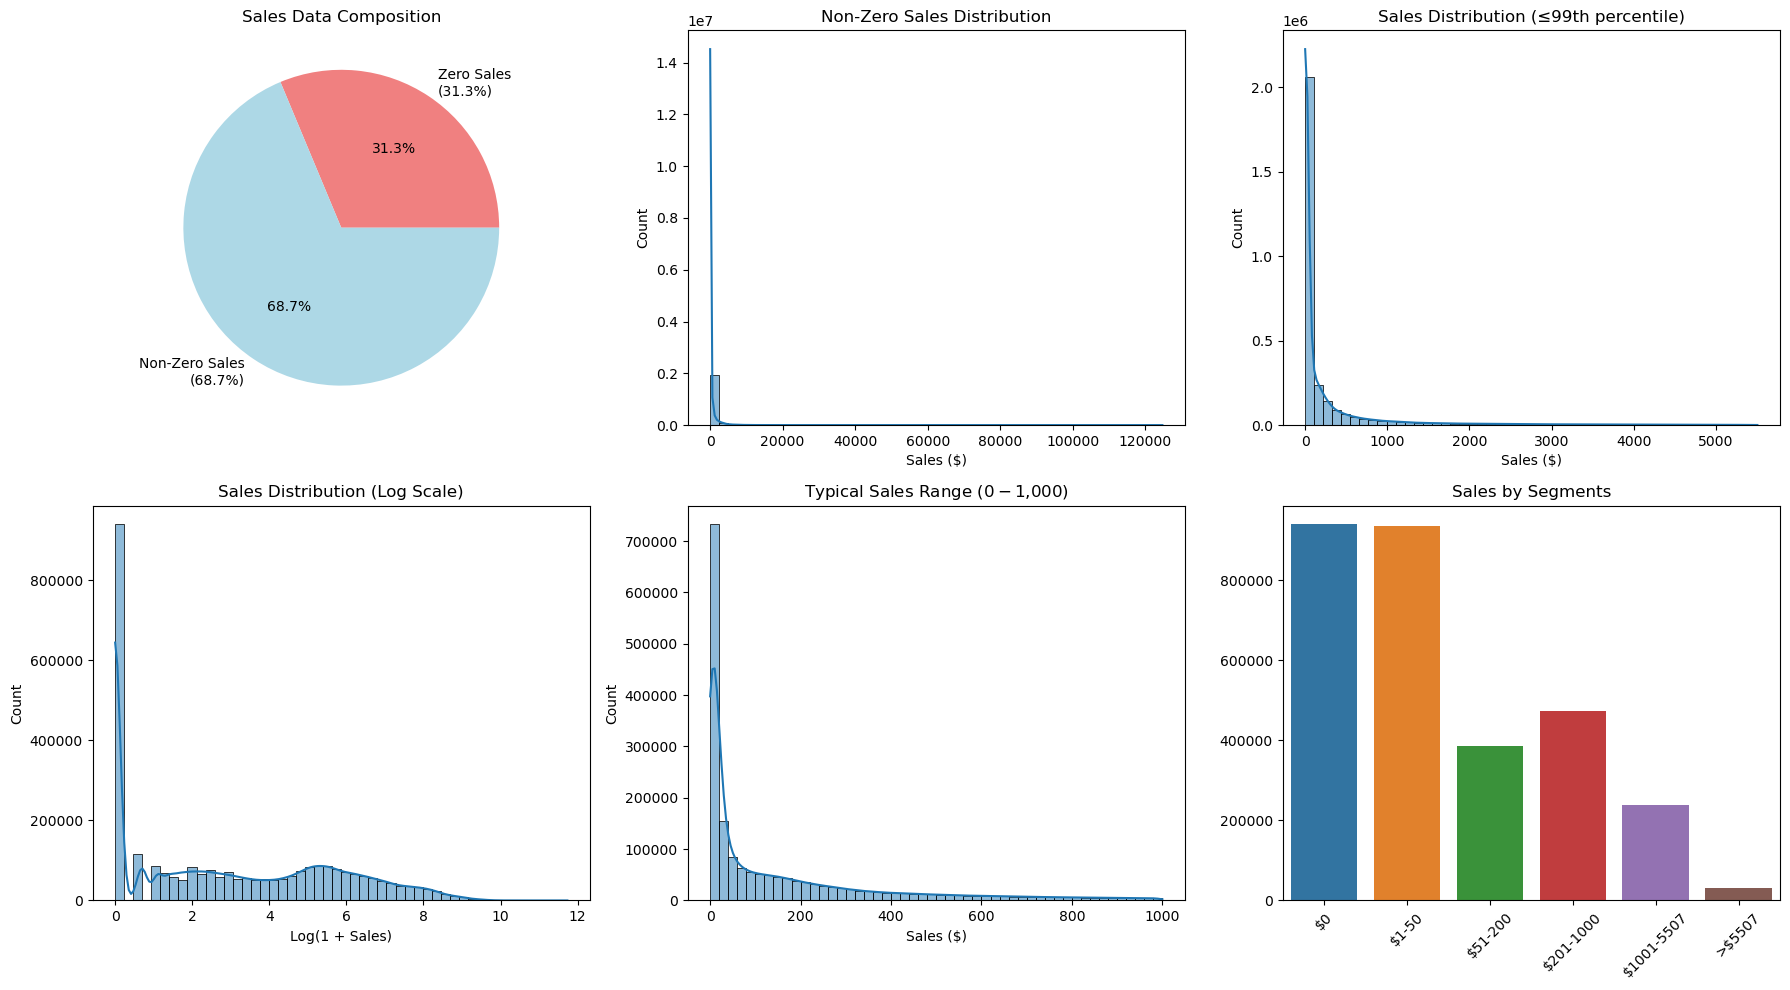

=== SALES SEGMENTS ANALYSIS ===
$0: 939,130 records (31.3%)
$1-50: 934,152 records (31.1%)
$51-200: 385,958 records (12.9%)
$201-1000: 473,049 records (15.8%)
$1001-5507: 238,591 records (8.0%)
>$5507: 30,008 records (1.0%)


In [ ]:
# 1. Data Overview
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# A. Zero vs Non-Zero Sales
zero_counts = [939130, len(train_df) - 939130]
labels = ['Zero Sales\n(31.3%)', 'Non-Zero Sales\n(68.7%)']
colors = ['lightcoral', 'lightblue']
axes[0,0].pie(zero_counts, labels=labels, colors=colors, autopct='%1.1f%%')
axes[0,0].set_title('Sales Data Composition')

# B. Non-Zero Sales Distribution (Much more meaningful)
non_zero_sales = train_df[train_df['sales'] > 0]['sales']
sns.histplot(non_zero_sales, bins=50, kde=True, ax=axes[0,1])
axes[0,1].set_title('Non-Zero Sales Distribution')
axes[0,1].set_xlabel('Sales ($)')

# C. Sales up to 99th percentile (Remove extreme outliers)
sales_99 = train_df[train_df['sales'] <= 5507]['sales']
sns.histplot(sales_99, bins=50, kde=True, ax=axes[0,2])
axes[0,2].set_title('Sales Distribution (≤99th percentile)')
axes[0,2].set_xlabel('Sales ($)')

# D. Log transformation (Handles skewness)
train_df['sales_log1p'] = np.log1p(train_df['sales'])
sns.histplot(train_df['sales_log1p'], bins=50, kde=True, ax=axes[1,0])
axes[1,0].set_title('Sales Distribution (Log Scale)')
axes[1,0].set_xlabel('Log(1 + Sales)')

# E. Focus on "typical" sales (median ± reasonable range)
typical_sales = train_df[(train_df['sales'] > 0) & (train_df['sales'] <= 1000)]['sales']
sns.histplot(typical_sales, bins=50, kde=True, ax=axes[1,1])
axes[1,1].set_title('Typical Sales Range ($0-$1,000)')
axes[1,1].set_xlabel('Sales ($)')

# F. Sales segments analysis
segments = ['$0', '$1-50', '$51-200', '$201-1000', '$1001-5507', '>$5507']
segment_counts = [
    (train_df['sales'] == 0).sum(),
    ((train_df['sales'] > 0) & (train_df['sales'] <= 50)).sum(),
    ((train_df['sales'] > 50) & (train_df['sales'] <= 200)).sum(),
    ((train_df['sales'] > 200) & (train_df['sales'] <= 1000)).sum(),
    ((train_df['sales'] > 1000) & (train_df['sales'] <= 5507)).sum(),
    (train_df['sales'] > 5507).sum()
]
sns.barplot(x=segments, y=segment_counts, ax=axes[1,2])
axes[1,2].set_title('Sales by Segments')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print segment analysis
print("=== SALES SEGMENTS ANALYSIS ===")
total_records = len(train_df)
for i, (segment, count) in enumerate(zip(segments, segment_counts)):
    pct = (count / total_records) * 100
    print(f"{segment}: {count:,} records ({pct:.1f}%)")


**Key Business Insights:**

Customer Behavior:
- High frequency, low value transactions dominate
- Typical purchase: $1-50 (daily items)
- Large purchases rare but significant in total revenue

Potential Modeling Implications:
- Log transformation essential - Handles the skewness
- Zero-inflation models might be needed (31% zeros)
- Separate models for different sales segments could work well
- Focus on 0 − 1000 range for most analysis